## 테스트용 파일이름 추출 및 정리
### 캡션 예측용 사진 다운로드
### 모델훈련시 저장한 테스트용 데이터 파일 로드 후 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd

In [29]:
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)


else:
  PATH = os.path.abspath('.') + image_folder

image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645022720/6645013297 [==============================] - 128s 0us/step


In [30]:
# 드라이브에 폴더생성
os.mkdir("/content/Multi")

In [31]:
!unzip -uq "/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/MultiModule.zip" -d "/content/Multi/"

In [32]:
len(os.listdir("/content/Multi"))

24010

In [33]:
PATH = '/content/'

In [ ]:
# import pandas as pd
# df_MS = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/MS_COCO_데이터정리(완료).csv')
# df_MS['사진경로'] = PATH + df_MS['사진경로']
# print(len(df_MS))
# df_MS.head()

In [ ]:
# import pandas as pd
# df_Multi = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/멀티모달_데이터정리(완료).csv')
# df_Multi['사진경로'] = '/content/' + df_Multi['사진이름']
# print(len(df_Multi))
# df_Multi.head()

In [47]:
# 테스트용 파일 이름 csv 호출
# import pandas as pd
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/testImage_Nam(TK_OKT).csv')
print(len(df_test))
# df_test.head()

14727


In [ ]:
# BLEU 레퍼렌스 데이터 추출
# df_test_bleu = pd.merge(df_test, df_MS, left_on='testImage_Name', right_on='사진경로', how='left')[['사진경로', '캡셔닝_데이터']]
# print(len(df_test_bleu))
# df_test_bleu.to_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/df_test_bleu(TK_OKT).csv', index = False)
# df_test_bleu.head(5)

In [18]:
# df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/df_test_bleu(TK_OKT).csv')
# (df_test == df_test_bleu).value_counts()

사진경로  캡셔닝_데이터
True  True       73675
dtype: int64

In [34]:
df_test_bleu = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/df_test_bleu(TK_OKT).csv')

## 체크포인트 불러와서 테스트할 모델 로드하기


In [ ]:
# 사진 리사이징시 오류가 생기는 사진 파일 제외
# df_Multi = df_Multi[df_Multi['사진이름'] != 'KETI_SHOT_0000142253_KM_0000014468.jpg']
# df_Multi = df_Multi[df_Multi['사진이름'] != 'KETI_SHOT_0000123067_KM_0000000834.jpg']
# df_Multi.reset_index(drop = True, inplace = True)

In [35]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) 
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [36]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [37]:
df_Tk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/tokenizer(word_to_index_Okt).csv')
df_Tk.head()

,word,index
0,pad,0
1,unk,1
2,start,2
3,안경,3
4,을,4


In [22]:
!pip3 install konlpy

In [23]:
from tqdm.notebook import tqdm
from konlpy.tag import Okt
tokenizer = Okt()
word_to_index = dict(zip(df_Tk['word'], df_Tk['index']))
index_to_word = dict(zip(df_Tk['index'], df_Tk['word']))
len(word_to_index) ,len(index_to_word)

(27541, 27541)

In [24]:
# Feel free to change these parameters according to your system's configuration
# 해당 모델에 들어가야하는 필수 변수들이며, 학습시킬때의 수치와 일치화 시켜주었습니다.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(index_to_word) 
max_length = 58
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## 모델 로드

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [28]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoint(Ko_Okt)/train(val_image)'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50) 
ckpt.restore(ckpt_manager.latest_checkpoint)
# encoder.summary()
# decoder.summary()

In [38]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_input = tf.expand_dims([word_to_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(index_to_word[predicted_id])

        # if tokenizer.index_word[predicted_id] == '<end>':
        #     return result, attention_plot
        if index_to_word[predicted_id] == 'end':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
# !pip install git+https://github.com/ssut/py-hanspell.git

In [39]:
import os
path_dir = '/content/val2014/'
file_dir = os.listdir(path_dir)
path_dir + file_dir[0]

'/content/val2014/COCO_val2014_000000401112.jpg'

/content/train2014/COCO_train2014_000000283666.jpg
예측문장1: 배구 그물 로 장식 이 보인다 end
예측문장2: 말 을 탄 기수 들 이 경주 를 하고 있다 end
예측문장3: 어떤 사람 이 말 을 타는 사람 들 end
예측문장4: 말 들 이 트랙 을 걸어가고 있다 end
예측문장5: 네 명의 사람 이 두 마리 말 이 트랙 을 따라 흙 위 에 앉아 있다 end


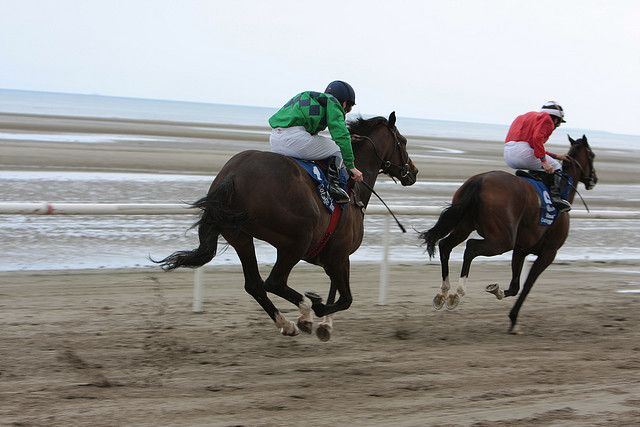

In [42]:
# from hanspell import spell_checker
import random 
i = random.randint(0, len(file_dir))
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-3:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
# image_path = '/content/1.jpg'
# image_path = path_dir + file_dir[i]
image_path = df_test_bleu['사진경로'][11]
print(image_path)

prediction_list = []
for i in range(5):
  result, attention_plot = evaluate(image_path)
  caption = ' '.join(result)
  print(f'예측문장{i+1}:', caption)
  # print(f'예측문장{i+1}(원래문장):', ' '.join(result))
  prediction_list.append(caption)
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## 모델 로드후 Bleu score 계산

In [45]:
preprocessed_sentences = []
for i in tqdm(range(len(df_test_bleu))):
    result = tokenizer.morphs(df_test_bleu['캡셔닝_데이터'][i])
    preprocessed_sentences.append(result)
df_test_bleu['캡셔닝_데이터(토큰화_Okt)'] = preprocessed_sentences    
df_test_bleu.head()

  0%|          | 0/73675 [00:00<?, ?it/s]

,사진경로,캡셔닝_데이터,캡셔닝_데이터(토큰화_Okt)
0,/content/train2014/COCO_train2014_000000457734...,한 여성이 자신의 자동차에서 얼룩말의 사진을 찍는다,"[한, 여성, 이, 자신, 의, 자동차, 에서, 얼룩말, 의, 사진, 을, 찍는다]"
1,/content/train2014/COCO_train2014_000000457734...,어른 얼룩말이 차의 조수석 창문 근처에 서 있다,"[어른, 얼룩말, 이, 차, 의, 조, 수석, 창문, 근처, 에, 서, 있다]"
2,/content/train2014/COCO_train2014_000000457734...,밝은 날에 차 옆에 서 있는 얼룩말,"[밝은, 날, 에, 차, 옆, 에, 서, 있는, 얼룩말]"
3,/content/train2014/COCO_train2014_000000457734...,차량 근처에 서 있는 얼룩말의 근접 촬영지입니다,"[차량, 근처, 에, 서, 있는, 얼룩말, 의, 근접, 촬영, 지, 입니다]"
4,/content/train2014/COCO_train2014_000000457734...,얼룩말과 측면 거울에 비친 암컷,"[얼룩말, 과, 측면, 거울, 에, 비친, 암컷]"


In [ ]:
list(df_test_bleu[df_test_bleu['사진경로'] == df_test_bleu['사진경로'][0]]['캡셔닝_데이터(토큰화_Okt)'])

['한 여성이 자신의 자동차에서 얼룩말의 사진을 찍는다 ',
 '어른 얼룩말이 차의 조수석 창문 근처에 서 있다 ',
 '밝은 날에 차 옆에 서 있는 얼룩말',
 '차량 근처에 서 있는 얼룩말의 근접 촬영지입니다 ',
 '얼룩말과 측면 거울에 비친 암컷']

In [46]:
# df_test_bleu 딕셔너리 변환
from tqdm.notebook import tqdm
bleu_dict = dict()
for name in tqdm(df_test_bleu['사진경로']):
  bleu_dict[name] = list(df_test_bleu[df_test_bleu['사진경로'] == name]['캡셔닝_데이터(토큰화_Okt)'])

  0%|          | 0/73675 [00:00<?, ?it/s]

In [50]:
df_test['testImage_Name'][0]

'/content/train2014/COCO_train2014_000000457734.jpg'

In [51]:
len(bleu_dict), bleu_dict[df_test['testImage_Name'][0]]

(14727,
 [['한', '여성', '이', '자신', '의', '자동차', '에서', '얼룩말', '의', '사진', '을', '찍는다'],
  ['어른', '얼룩말', '이', '차', '의', '조', '수석', '창문', '근처', '에', '서', '있다'],
  ['밝은', '날', '에', '차', '옆', '에', '서', '있는', '얼룩말'],
  ['차량', '근처', '에', '서', '있는', '얼룩말', '의', '근접', '촬영', '지', '입니다'],
  ['얼룩말', '과', '측면', '거울', '에', '비친', '암컷']])

In [56]:
# 참고사이트 : https://jrc-park.tistory.com/273
from nltk.translate.bleu_score import corpus_bleu # 레퍼렌스가 여러개일떄 sentence_bleu는 점수가 상승할 수 밖에 없음. / 여러문장을 비교할때는 corpus_bleu를 사용
from nltk.translate.bleu_score import sentence_bleu

def print_bleu(reference, candidate):
  # bleu_sentence = sentence_bleu(reference, candidate)
  bleu_1gram = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)) # weights를 0.25로 동일하게 주면 1gram부터 4gram까지 같은 수치로 계산(gram이 높아질 수록 연계된 순서를 2~4개까지 고려)

In [57]:
reference = [["this", "is", "the", "sample"]] 
	    #  ["this", "the", "good","sample"]]
candidate = ['this', "is", "a", "good", "sample"]
sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6

In [53]:
# 각 단어의 일치여부만 확인하는 유니그램형태로 분석.
references = bleu_dict[df_test['testImage_Name'][0]]
references

[['한', '여성', '이', '자신', '의', '자동차', '에서', '얼룩말', '의', '사진', '을', '찍는다'],
 ['어른', '얼룩말', '이', '차', '의', '조', '수석', '창문', '근처', '에', '서', '있다'],
 ['밝은', '날', '에', '차', '옆', '에', '서', '있는', '얼룩말'],
 ['차량', '근처', '에', '서', '있는', '얼룩말', '의', '근접', '촬영', '지', '입니다'],
 ['얼룩말', '과', '측면', '거울', '에', '비친', '암컷']]

In [59]:
result, attention_plot = evaluate(df_test['testImage_Name'][0])
# result.remove('<end>')
candidate = result[:-1]
print(candidate)

['밝은', '마당', '에', '얼룩말', '이', '앞', '에', '서', '있었다']


In [60]:
sentence_bleu(references, candidate, weights=(1, 0, 0, 0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6666666666666666

## 1차 테스트 결과 : Bleu_Score Average : 0.4020168367225402
## 2차 테스트 결과 : Bleu_Score Average : 0.40122324726829256

In [63]:
# 오류 참고 사이트 : https://github.com/nltk/nltk/issues/1838
# 유니그램만 계산
from tqdm.notebook import tqdm
bleu_list = []
for image_path in tqdm(df_test['testImage_Name']):
  references = bleu_dict[image_path]
  result, attention_plot = evaluate(image_path)
  candidate = result[:-1]
  bleu_score = sentence_bleu(references, candidate, weights=(1, 0, 0, 0))
  bleu_list.append(bleu_score)
print(f'Bleu_Score Average : {sum(bleu_list) / len(bleu_list)}')

  0%|          | 0/14727 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu_Score Average : 0.40122324726829256


In [ ]:
# 유니그램만 계산 / 1개의 사진당 5개를 예측하고, 각각의 예측값과 원래 캡션과의 bleu 점수 계산 후 평균을 작성하여 리스트에 추가하요 평균값들의 평균을 계산
from tqdm.notebook import tqdm
bleu_list = []
for image_path in tqdm(df_test['testImage_Name']):
  bleu_score_list = []
  references = bleu_dict[image_path]
  for _ in range(5):
    result, attention_plot = evaluate(image_path)
    candidate = result[:-1]
    bleu_score = sentence_bleu(references, candidate, weights=(1, 0, 0, 0))
    bleu_score_list.append(bleu_score)
  img_bleu_avg = (sum(bleu_score_list) / len(bleu_score_list))
  bleu_list.append(img_bleu_avg)
print(f'Bleu_Score Average : {(sum(bleu_list) / len(bleu_list))}')